In [26]:
import scVI
import tensorflow as tf
from benchmarking import *
from helper import *

import numpy as np
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

## Load Data

In [3]:

X_type = pd.read_csv("../../data/cell.type_E31.csv", sep=",")
cell_types, cluster_labels = np.unique(np.array(X_type)[:,1], return_inverse=True)

print("Number of cluster labels",len(cluster_labels))


Number of cluster labels 3381


In [27]:
cell_types, cluster_labels

(array(['AS', 'EN', 'MG', 'MU', 'N', 'OL', 'OPC', 'UA'], dtype=object),
 array([4, 4, 4, ..., 3, 4, 4]))

In [6]:

# dge = np.load("../../data/dge_E31.dat")
dge = pd.read_csv("../../data/dge_E31.csv", index_col = 0)
# Get the expression matrix: Cell * Genes

X = dge.values.T
cell_names = dge.columns.values
cell_names2 = np.array(X_type)[:,0]

In [28]:
X.shape

(3381, 16124)

In [7]:
# Make sure the cell name matchs
for i in range(len(cell_names)):
    # print(cell_names[i], cell_names2[i])
    if cell_names[i] not in cell_names2[i]:
        print("Not match", cell_names[i], cell_names2)[i]

gene_names = dge.index.tolist()
print(dge.shape)

(16124, 3381)


In [11]:
# split dataset into train and test
expression_train, expression_test, c_train, c_test = train_test_split(X, cluster_labels, random_state=0)

In [12]:
log_library_size = np.log(np.sum(expression_train, axis=1))
mean, var = np.mean(log_library_size), np.var(log_library_size)

batch_size = 128
learning_rate = 0.001
epsilon = 0.01
latent_dimension = 10


In [14]:
tf.reset_default_graph()
expression = tf.placeholder(tf.float32, (None, expression_train.shape[1]), name='x')
kl_scalar = tf.placeholder(tf.float32, (), name='kl_scalar')
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, epsilon=epsilon)
training_phase = tf.placeholder(tf.bool, (), name='training_phase')

# getting priors
log_library_size = np.log(np.sum(expression_train, axis=1))
mean, var = np.mean(log_library_size), np.var(log_library_size)
# loading data
model = scVI.scVIModel(expression=expression, kl_scale=kl_scalar, \
                         optimize_algo=optimizer, phase=training_phase, \
                          library_size_mean=mean, library_size_var=var, n_latent=latent_dimension)

#starting computing session
sess = tf.Session()

Running scVI on 16124 genes
scVI will run without batch correction
Will work on mode numeric for incorporating library size
Will work on mode gene for modeling inverse dispersion param
Will apply zero inflation
1 hidden layers at 128 each for a final 10 latent space


In [15]:
sess.run(tf.global_variables_initializer())
result = train_model(model, (expression_train, expression_test), sess, 250, batch_size=batch_size)

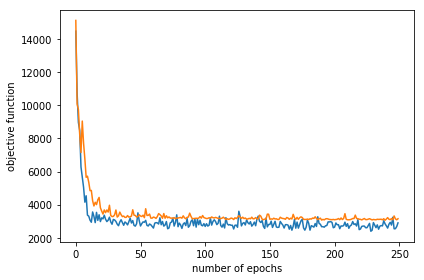

In [16]:
plot_training_info(result)


## Clustering

In [29]:
dic_full = {expression: expression_train, training_phase:False}
latent = sess.run(model.z, feed_dict=dic_full)
clustering_score = cluster_scores(latent, len(cell_types), c_train)
print("Silhouette", clustering_score[0], "\nAdjusted Rand Index", clustering_score[1], \
        "\nNormalized Mutual Information", clustering_score[2])

Silhouette 0.24821118 
Adjusted Rand Index 0.828178564716114 
Normalized Mutual Information 0.7434464960774062


In [24]:
latent.shape

(2535, 10)

## Visualization

In [20]:
def  show_tSNEshow_tSN (latent, labels):
    tsne = TSNE().fit_transform(latent)
    plt.figure(figsize=(5, 5))
    plt.scatter(tsne[:, 0], tsne[:, 1], c=labels, \
                                   cmap=plt.get_cmap("tab10", 7), edgecolors='none')
    plt.axis("off")

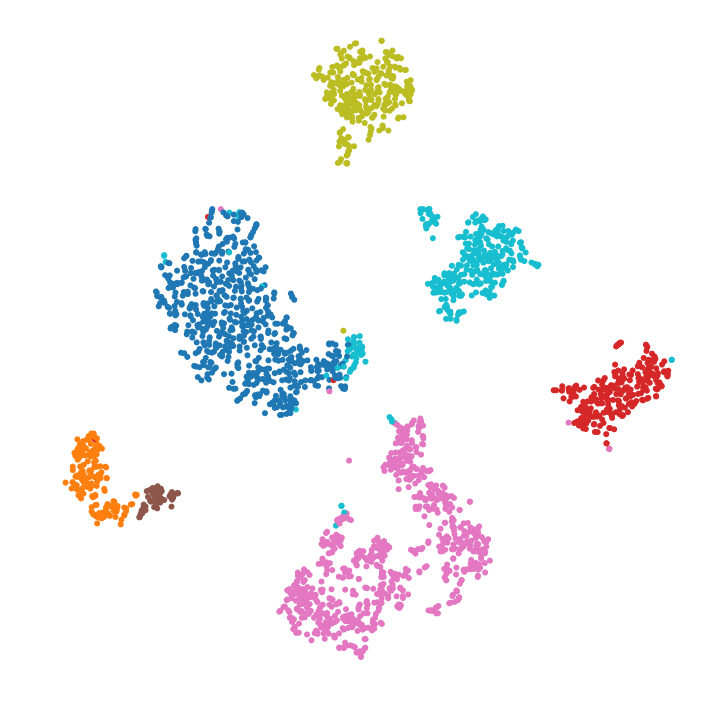

In [21]:
show_tSNE(latent, c_train)
